In [19]:
import MDAnalysis as mda
import MDAnalysis.transformations as trans
from MDAnalysis.transformations.positionaveraging import PositionAverager

In [20]:
# Load in the reference structure
ref_structure = "protein_initial_unaligned.gro"
ref = mda.Universe(ref_structure)
atoms_ref_kras_bb = ref.select_atoms("name BB")

In [21]:
# Load in the trajectory
traj_file = "protein_bb_unaligned_pbc_fixed.trr"
mobile = mda.Universe(ref_structure, traj_file, in_memory=True)
atoms_mobile_kras_bb = mobile.select_atoms("name BB")

In [22]:
# Check the RMSD before alignment
mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name BB')
ref_ca = ref.select_atoms('name BB')
unaligned_rmsd =  mda.analysis.rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)
print(f"Unaligned RMSD: {unaligned_rmsd:.2f}")

Unaligned RMSD: 328.56


In [23]:
# Transforms:
# 1) Center on KRAS CYF B
# 2) translate up in z axes 
# 3) wrap all particles into the box 

# TODO: what's the best residue to center on
atoms_mobile_kras_CYF_bb  = mobile.select_atoms("index 250")
transforms = [trans.center_in_box(atoms_mobile_kras_CYF_bb),
              trans.translate([0,0,40]),
              trans.wrap(mobile.atoms)]
mobile.trajectory.add_transformations(*transforms)

In [ ]:
# Alignment:
aligner = mda.analysis.align.AlignTraj(mobile, ref, select="name BB", in_memory=True).run()

with mda.Writer("mda_aligned_traj.pdb", mobile.atoms.n_atoms) as writer:
    for ts in mobile.trajectory:
        writer.write(mobile)

In [25]:
mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name BB')
ref_ca = ref.select_atoms('name BB')
unaligned_rmsd =  mda.analysis.rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)
print(f"Aligned RMSD: {unaligned_rmsd:.2f}")

Aligned RMSD: 4.71


Text(0, 0.5, 'RMSD')

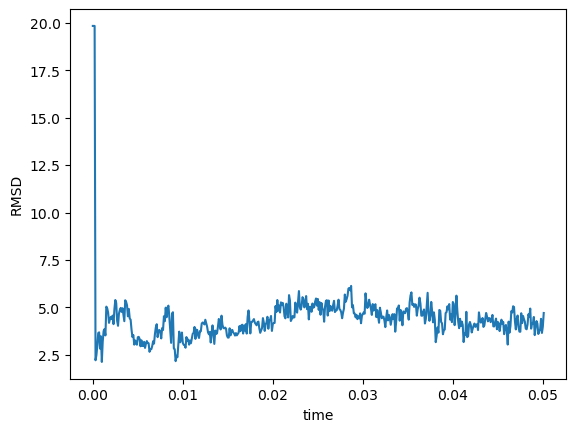

In [26]:
import numpy as np
import matplotlib.pyplot as plt

data = np.zeros([len(mobile.trajectory),2], dtype= float)
i=0
for ts in mobile.trajectory:
    data[i,0] = mobile.trajectory.time / 1000
    data[i,1] = mda.analysis.rms.rmsd(atoms_mobile_kras_bb.positions, atoms_ref_kras_bb.positions, weights=None, center=False, superposition=False)
    i=i+1

plt.plot(data[:,0], data[:,1])
plt.xlabel("time")
plt.ylabel("RMSD")

In [32]:
# Compute average structure across all frames
N=502

aligned_traj_file = "mda_aligned_traj.pdb"
mobile_aligned = mda.Universe(aligned_traj_file)

transformation = PositionAverager(N, check_reset=True)
mobile_aligned.trajectory.add_transformations(transformation)

for ts in mobile_aligned.trajectory:
    # This applies the transformation across all frames
    pass

with mda.Writer("mda_struct_ave.pdb", mobile_aligned.atoms.n_atoms) as writer:
    writer.write(mobile_aligned.atoms)

/opt/miniconda3/envs/mdsims/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/opt/miniconda3/envs/mdsims/lib/python3.12/site-packages/MDAnalysis/transformations/positionaveraging.py:193: Warning: Cannot average position for non sequentialiterations. Averager will be reset.
  warnings.warn('Cannot average position for non sequential'
/opt/miniconda3/envs/mdsims/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/opt/miniconda3/envs/mdsims/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found 